# Threshold tuning


For each model, we investigate the performance changes we get by tuning the threshold. In general, we deem more important to improve the Recall. Therefore we predict that a lowering of the threshold may be advantageous to us. 

## Load libraries and data 

### Load modules

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, recall_score, make_scorer


from sklearn.linear_model import LogisticRegression

from matplotlib_venn import venn2
from tqdm import tqdm

from imblearn.over_sampling import SMOTENC



import src.features as features
import src.model_selection as model_selection 
import src.functions as functions
import src.datasets as datasets 

# import custom functions
from src.functions import plot_correlations, plot_mutual_info, hello
from src.datasets import xy_train, xy_train_test, data_original, data_50000, data_balanced



In [4]:
import pickle

In [5]:
from imblearn.pipeline import Pipeline, make_pipeline
# https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html

### Load dataset

In [153]:
data = datasets.data_original()

### Feature engineering 

In [154]:
data = features.engineer(data)

### Train test split (unprocessed)

In [155]:
X_, y_ = data.drop('infected', axis=1), data['infected']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.2, random_state=42, stratify = y_)


### Scaling the data 

In [156]:
scaler = StandardScaler()

scaler.fit(X_train_)

X_train_scaled = scaler.transform(X_train_)
X_test_scaled = scaler.transform(X_test_)

### Data ready for Machine Learning

In [157]:
X_train = pd.DataFrame(X_train_scaled,columns=X_.columns)
X_test = pd.DataFrame(X_test_scaled,columns=X_.columns)
y_train = y_train_ 
y_test = y_test_ 

## Threshold tuning functions

In [46]:

def threshold_results(Xtest, ytest, fit_model, title= "modelname"):
  """ returns a dataframe with columns 
    "model, threshold, accuracy, recall, selectivity, f1, f3, precision, NPV"
  you can plot the acc_recall_curve with sns.lineplot(data=results, x='recall', y='accuracy', hue='model')
  title = string description of the model, the df and the technique used
  """

  yproba = fit_model.predict_proba(Xtest)[:,1]
  auc = roc_auc_score(ytest, yproba)


  results = []
  thresholds = np.arange(0.05, 0.6, 0.01)

  for threshold in thresholds:
    ypred = (yproba > threshold).astype(int)

    results.append({
        "model": title,
        "threshold": threshold,
        "accuracy": accuracy_score(ytest,ypred),
        "recall": recall_score(ytest,ypred),
        "selectivity": recall_score(ytest,ypred,pos_label = 0),
        "f1": f1_score(ytest,ypred),
        "f3": fbeta_score(ytest,ypred,beta = 3),
        "precision": precision_score(ytest,ypred),
        "NPV": precision_score(ytest,ypred, pos_label = 0),
        "ROC AUC": auc
    })
  results_df = pd.DataFrame(results)
  #results_df.set_index("threshold", inplace=True) 
  return results_df



In [92]:
def notable_thresholds(thr_results):
    i_f3 = thr_results['f3'].idxmax()
    i_f1 = thr_results['f1'].idxmax()
    i_acc = thr_results['accuracy'].idxmax()
    i_th50 = thr_results.loc[thr_results["threshold"]<0.5001]['threshold'].idxmax()

    f3max = thr_results.iloc[i_f3].copy()
    f1max = thr_results.iloc[i_f1].copy()
    th50 = thr_results.iloc[i_th50].copy()
    accmax = thr_results.iloc[i_acc].copy()

    f3max["model"] += "_maxf3"
    f1max["model"] += "_maxf1"
    th50["model"] += "_thr50"
    accmax["model"] += "_maxacc"

    not_thresholds = pd.DataFrame([th50,accmax,f3max, f1max])
    not_thresholds.reset_index(inplace=True)
    return not_thresholds

In [93]:

def plot_acc_recall(thr_results, figsize = (4,2), show_notable = True):
  """
  you can concatenate a few results as pd.concat([results_rf, results_xgb])
  """

  plt.figure()
  sns.lineplot(data=thr_results, x='recall', y='accuracy', hue='model', markers = True, estimator = None)

  if show_notable:
    # Compute notable points: threshold_50, max_accuracy, max_f1, max_f3
    not_thresholds = notable_thresholds(thr_results)

    # Add notable points
    sns.scatterplot(data=not_thresholds, x='recall', y='accuracy', hue='model', s= 100)

    # Add threshold as text label for each point
    for i, threshold in enumerate(not_thresholds["threshold"]):
        txt  = f"{threshold:0.2f}"
        plt.text(not_thresholds["recall"][i], not_thresholds["accuracy"][i], txt, fontsize=10, ha='right', va='bottom')

  plt.show()

## Compute thresholds

### Train a model

In [ ]:
model = LogisticRegression(random_state=42)

with open("models/rfe_features_250103.pkl", "rb") as file:
    # we load the model with 8 features
    rfe_selected_features = pickle.load(file)[8]
X_train_rfe = X_train[rfe_selected_features]
X_test_rfe = X_test[rfe_selected_features]

print(rfe_selected_features)

In [18]:
model.fit(X_train_rfe,y_train)

LogisticRegression(random_state=42)

### Compute threshold results

In [47]:
results_rfe = threshold_results(X_test_rfe, y_test, model, "rfe 8 original")

In [94]:
notable_thresholds(results_rfe)

,index,model,threshold,accuracy,recall,selectivity,f1,f3,precision,NPV,ROC AUC
0,45,rfe 8 original_thr50,0.50,0.899533,0.759615,0.944444,0.786070,0.764763,0.814433,0.924471,0.921415
1,38,rfe 8 original_maxacc,0.43,0.901869,0.798077,0.935185,0.798077,0.798077,0.798077,0.935185,0.921415
2,4,rfe 8 original_maxf3,0.09,0.773364,0.913462,0.728395,0.662021,0.848972,0.519126,0.963265,0.921415
3,38,rfe 8 original_maxf1,0.43,0.901869,0.798077,0.935185,0.798077,0.798077,0.798077,0.935185,0.921415


### Visualize threshold results

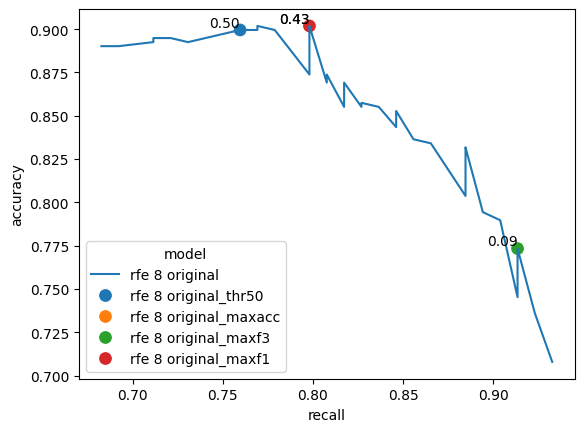

In [95]:
plot_acc_recall(results_rfe)

## Cross validation threshold computation

### CV threshold functions

In [158]:
from sklearn.base import clone


In [192]:
def cv_not_thr_results(Xtrain, ytrain, model, title= "modelname", verbose = False, n_splits = 5):
    # Create the K-Fold cross-validator
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    X_train_reindexed = Xtrain.copy()
    X_train_reindexed.reset_index(inplace=True, drop = True)
    y_train_reindexed = ytrain.copy()
    y_train_reindexed.reset_index(drop=True, inplace=True)
    
    cv_thr_results_list = []
    not_thr_results_list = []
    i = 0

    # source https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
    for train_fold_index, val_fold_index in cv.split(X_train_reindexed, y_train_reindexed):
        


        # Get the training data
        X_train_fold, y_train_fold = X_train_reindexed.iloc[train_fold_index], y_train_reindexed[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train_reindexed.iloc[val_fold_index], y_train_reindexed[val_fold_index]

        if verbose:
            print("fold number :", i)

        # create a untrained copy of the model with same hyperparameters
        model_cv = clone(model)
        
        model_cv.fit(X_train_fold, y_train_fold)

        cv_thr_result = threshold_results(X_val_fold, y_val_fold,model_cv,title + "_cv" + str(i))
        cv_thr_results_list.append(cv_thr_result)

        not_thr_result = notable_thresholds(cv_thr_result)
        not_thr_results_list.append(not_thr_result)

        i += 1

    cv_thr_result_df = pd.concat(cv_thr_results_list)
    not_thr_result_df = pd.concat(not_thr_results_list)

    cv_thr_result_df.reset_index(inplace = True)
    not_thr_result_df.reset_index(inplace = True)
    return (cv_thr_result_df,not_thr_result_df)

def cv_threshold_results(Xtrain, ytrain, model, title= "modelname", n_splits = 5, verbose = False):
    return cv_not_thr_results(Xtrain, ytrain, model, title= title, n_splits= n_splits, verbose=verbose)[0]

def cv_mean_threshold_from_results(cv_thr_results):
    title = cv_thr_results.loc[0,"model"][:-1]
    cv_mean_thr_results = cv_thr_results.drop(columns = ["model"]).groupby("threshold").mean()
    cv_mean_thr_results.reset_index(inplace = True)
    cv_mean_thr_results["model"] = title + "_cv"
    return cv_mean_thr_results


def cv_mean_threshold_results(Xtrain, ytrain, model, title= "modelname", n_splits = 5, verbose = False):
    cv_thr_results = cv_not_thr_results(Xtrain, ytrain, model, title= title, n_splits= n_splits, verbose=verbose)[0]
    cv_mean_thr_results = cv_thr_results.drop(columns = ["model"]).groupby("threshold").mean()
    cv_mean_thr_results.reset_index(inplace = True)
    cv_mean_thr_results["model"] = title + "_cv"
    return cv_mean_thr_results



        


### Create the model pipeline

In [160]:
model = LogisticRegression(random_state=42)

with open("models/rfe_features_250103.pkl", "rb") as file:
    # we load the model with 8 features
    rfe_selected_features = pickle.load(file)[8]
X_train_rfe = X_train[rfe_selected_features]
X_test_rfe = X_test[rfe_selected_features]

print(rfe_selected_features)

['hemo', 'drugs', 'z30', 'race', 'gender', 'offtrt', 'cd420', 'time730']


### Compute thresholds in cross validation

In [193]:
cv_thresholds_rfe = cv_threshold_results(X_train_rfe,y_train,model, "rfe 8 origin", verbose = True)


fold number : 0
fold number : 1
fold number : 2
fold number : 3
fold number : 4


In [195]:
cv_mean_thresholds_rfe = cv_mean_threshold_from_results(cv_thresholds_rfe)

In [198]:
notable_thresholds(cv_mean_thresholds_rfe)

,level_0,threshold,index,accuracy,recall,selectivity,f1,f3,precision,NPV,ROC AUC,model
0,45,0.50,45.0,0.888359,0.745812,0.934300,0.764976,0.749278,0.789229,0.919689,0.937786,rfe 8 origin_cv_cv_thr50
1,47,0.52,47.0,0.891866,0.738612,0.941256,0.768712,0.744247,0.804352,0.918097,0.937786,rfe 8 origin_cv_cv_maxacc
2,4,0.09,4.0,0.798943,0.942427,0.752680,0.696140,0.879876,0.552741,0.976292,0.937786,rfe 8 origin_cv_cv_maxf3
3,44,0.49,44.0,0.889525,0.757774,0.931980,0.769382,0.759711,0.786107,0.923158,0.937786,rfe 8 origin_cv_cv_maxf1


### Visualize threshold results in cross validadion

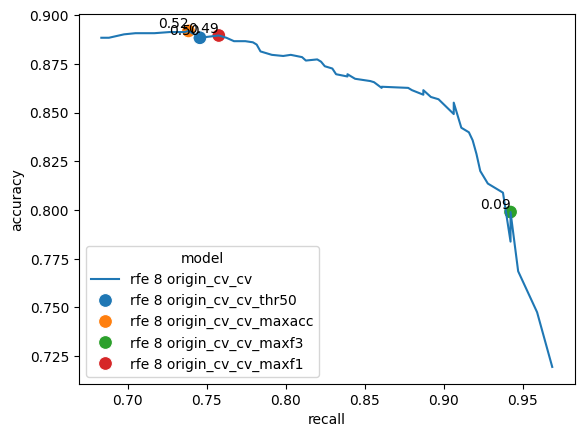

In [196]:
plot_acc_recall(cv_mean_thresholds_rfe)

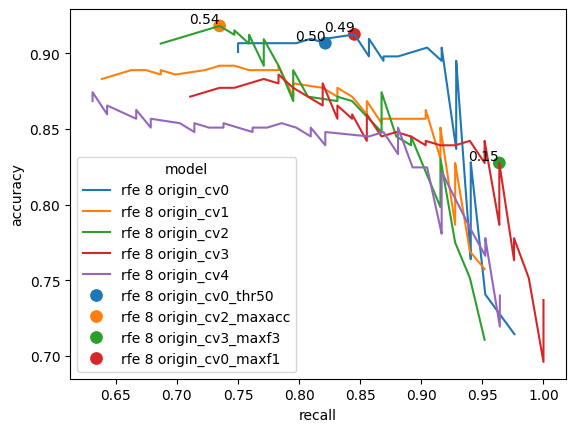

In [197]:
plot_acc_recall(cv_thresholds_rfe)